<a href="https://colab.research.google.com/github/aureguerrero/plantas/blob/main/Preparando_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip intall affine
!pip install pyproj
!pip install pygeoj
!pip install geopandas

     |████████████████████████████████| 19.3 MB 72.9 MB/s 
ERROR: unknown command "intall" - maybe you meant "install"
     |████████████████████████████████| 6.3 MB 12.5 MB/s 
  Created wheel for pygeoj: filename=PyGeoj-1.0.0-py3-none-any.whl size=10347 sha256=4f69445f88555b75bb23f58bf6d849b8856df7328aadd104b3d3ef70be352d2b
  Stored in directory: /root/.cache/pip/wheels/16/4b/11/0803a9faf4f6c123ca96cda96ef3a01a1b82a0671417dcedaf
Successfully built pygeoj
     |████████████████████████████████| 1.0 MB 27.7 MB/s 
     |████████████████████████████████| 15.4 MB 56.1 MB/s 


In [2]:
import gdal
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
import pygeoj
import geopandas as gpd
import matplotlib.pyplot as plt
import cv2
import shutil
import random as rd
import os

In [ ]:
nombre='dji-0342crop_maiz'

In [ ]:

df = gpd.read_file('/content/drive/Shareddrives/Conteo de plantas/SET INPUT DATA/Imágenes + Vectorización/'+nombre+'_vectorizado.geojson')


In [ ]:


fname = '/content/drive/Shareddrives/Conteo de plantas/SET INPUT DATA/Imágenes + Vectorización/'+nombre+'.tif'

# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values

# # All rows and columns
# cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# # Get affine transform for pixel centres
# T1 = T0 * Affine.translation(0.5, 0.5)
# # Function to convert pixel row/column index (from 0) to easting/northing at centre
# rc2en = lambda r, c: (c, r) * T1

# # All eastings and northings (there is probably a faster way to do this)
# eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# # Project all longitudes, latitudes
# p2 = Proj(proj='latlong',datum='WGS84')
# longs, lats = transform(p1, p2, eastings, northings)


In [ ]:
plantas={'id':[],'coord':[],'minx':[],'maxx':[],'miny':[],'maxy':[]}
for i in range(0,len(df)):
  a=df['geometry'][i]
  points = []
  for polygon in a:
    points.extend(polygon.exterior.coords[:-1])
  points =np.array([point for polygon in a for point in polygon.exterior.coords[:-1]])
  points[:,0]=np.int16((points[:,0]-T0[2])/T0[0])
  points[:,1]=np.int16((points[:,1]-T0[5])/T0[4])
  minx, maxx, miny, maxy=np.int16(np.min(points[:,0])), np.int16(np.max(points[:,0])),np.int16(np.min(points[:,1])), np.int16(np.max(points[:,1]))
  #plantas.append({'coord':points,'extrem':[[minx,maxx],[miny,maxy]]})
  plantas['id'].append(i), plantas['coord'].append(points), plantas['minx'].append(minx),plantas['maxx'].append(maxx),plantas['miny'].append(miny),plantas['maxy'].append(maxy)
  # plantas['id']=np.array(plantas['id'])
  # plantas['coord']=np.array(plantas['coord'])
  # plantas['minx']=np.array(plantas['minx'])
  # plantas['maxx']=np.array(plantas['maxx'])
  # plantas['miny']=np.array(plantas['miny'])
  # plantas['maxy']=np.array(plantas['maxy'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  import sys


In [ ]:
image=gdal.Open(fname).ReadAsArray().transpose([1,2,0])

In [ ]:
np.shape(image)

(1745, 2736, 3)

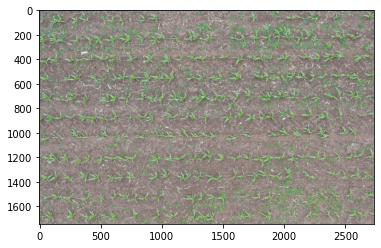

In [ ]:
plt.imshow(image)

In [ ]:
n=[np.shape(image)[0]//512,np.shape(image)[1]//512]
for i in range(0,n[0]):
  for j in range(0,n[1]):
    recorte=image[i*512:(i+1)*512,j*512:(j+1)*512,:]
    cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
    np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".npy",[plantas['coord'][t] for t in pos])
  recorte=image[i*512:(i+1)*512,np.shape(image)[1]-512:np.shape(image)[1],:]
  cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >n[1]-512)),np.where(np.array(plantas['maxx']) <n[1]))
  np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".npy",[plantas['coord'][t] for t in pos])

for j in range(0,n[1]):
  recorte=image[np.shape(image)[0]-512:np.shape(image)[0],j*512:(j+1)*512,:]
  cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >n[0]-512), np.where(np.array(plantas['maxy']) <n[0])),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
  np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".npy",[plantas['coord'][t] for t in pos])

recorte=image[np.shape(image)[0]-512:np.shape(image)[0],np.shape(image)[1]-512:np.shape(image)[1],:]
cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".png",recorte)
pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >n[0]-512), np.where(np.array(plantas['maxy']) <n[0])),np.where(np.array(plantas['minx']) >n[0]-512)),np.where(np.array(plantas['maxx']) <n[0]))
np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".npy",[plantas['coord'][t] for t in pos])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
fileDir = r"/content/drive/Shareddrives/Conteo de plantas/conj_ima/"
fileExt = r".png"
data_list_png=[_ for _ in os.listdir(fileDir) if _.endswith(fileExt)]
data_list_npy=[_ for _ in os.listdir(fileDir) if _.endswith(r".npy")]
pos=[l for l in range(0,len(data_list_png))]
rd.shuffle(pos)
split = int(0.8 *len(data_list))
train=pos[-split:]
test=pos[:-split]

In [ ]:
list_train_png=[data_list_png[t] for t in train]
list_train_npy=[data_list_npy[t] for t in train]
list_test_png=[data_list_png[t] for t in test]
list_test_npy=[data_list_npy[t] for t in test]

In [ ]:
for i,j in zip(list_train_png,list_train_npy):
  shutil.copy("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+i,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/"+i)
  shutil.copy("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+j,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/"+j)
for i,j in zip(list_test_png,list_test_npy):
  shutil.copy("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+i,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/"+i)
  shutil.copy("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+j,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/"+j)


# Pasar de json a csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(843, 2000, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1057, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1745, 2736, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1432, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


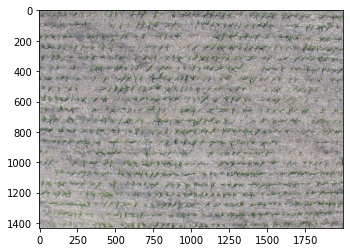

In [ ]:
archivos=['dji-0044crop_maiz','dji-0050crop_maiz','dji-0342crop_maiz','dji-0369crop_maiz']

for nombre in archivos:
  df = gpd.read_file('/content/drive/Shareddrives/Conteo de plantas/SET INPUT DATA/Imágenes + Vectorización/'+nombre+'_vectorizado.geojson')
  fname = '/content/drive/Shareddrives/Conteo de plantas/SET INPUT DATA/Imágenes + Vectorización/'+nombre+'.tif'

  # Read raster
  with rasterio.open(fname) as r:
      T0 = r.transform  # upper-left pixel corner affine transform
      p1 = Proj(r.crs)
      A = r.read()
  plantas={'id':[],'coord':[],'minx':[],'maxx':[],'miny':[],'maxy':[]}
  for i in range(0,len(df)):
    a=df['geometry'][i]
    points = []
    for polygon in a:
      points.extend(polygon.exterior.coords[:-1])
    points =np.array([point for polygon in a for point in polygon.exterior.coords[:-1]])
    points[:,0]=np.int16((points[:,0]-T0[2])/T0[0])
    points[:,1]=np.int16((points[:,1]-T0[5])/T0[4])
    minx, maxx, miny, maxy=np.int16(np.min(points[:,0])), np.int16(np.max(points[:,0])),np.int16(np.min(points[:,1])), np.int16(np.max(points[:,1]))
    #plantas.append({'coord':points,'extrem':[[minx,maxx],[miny,maxy]]})
    plantas['id'].append(i), plantas['coord'].append(points), plantas['minx'].append(minx),plantas['maxx'].append(maxx),plantas['miny'].append(miny),plantas['maxy'].append(maxy)
  image=gdal.Open(fname).ReadAsArray().transpose([1,2,0])
  print(np.shape(image))
  plt.imshow(image)
  n=[np.shape(image)[0]//512,np.shape(image)[1]//512]
  for i in range(0,n[0]):
    for j in range(0,n[1]):
      recorte=image[i*512:(i+1)*512,j*512:(j+1)*512,:]
      cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".png",recorte)
      pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
      np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,i*512] for t in pos])
    recorte=image[i*512:(i+1)*512,np.shape(image)[1]-512:np.shape(image)[1],:]
    cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
    np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,i*512] for t in pos])

  for j in range(0,n[1]):
    recorte=image[np.shape(image)[0]-512:np.shape(image)[0],j*512:(j+1)*512,:]
    cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
    np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,np.shape(image)[0]-512] for t in pos])

  recorte=image[np.shape(image)[0]-512:np.shape(image)[0],np.shape(image)[1]-512:np.shape(image)[1],:]
  cv2.imwrite("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
  np.save("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,np.shape(image)[0]-512] for t in pos])


In [ ]:
#Correr si solo queremos hacer un nuevo conj de testeo y entrenamiento

fileDir = r"/content/drive/Shareddrives/Conteo de plantas/conj_ima/"
fileExt = r".png"
data_list_png=[_ for _ in os.listdir(fileDir) if _.endswith(fileExt)]
data_list_npy=[_ for _ in os.listdir(fileDir) if _.endswith(r".npy")]
pos=[l for l in range(0,len(data_list_png))]
rd.shuffle(pos)
split = int(0.8 *len(data_list))
train=pos[-split:]
test=pos[:-split]
list_train_png=[data_list_png[t] for t in train]
list_train_npy=[data_list_npy[t] for t in train]
list_test_png=[data_list_png[t] for t in test]
list_test_npy=[data_list_npy[t] for t in test]

In [ ]:
fileDir = r"/content/drive/Shareddrives/Conteo de plantas/conj_ima/"
fileExt = r".png"
list_train_png=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(fileExt)]
list_train_npy=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(r".npy")]
list_test_png=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(fileExt)]
list_test_npy=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(r".npy")]
for i,j in zip(list_train_png,list_train_npy):
  shutil.move("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+i,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/"+i)
  shutil.move("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+j,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/"+j)
for i,j in zip(list_test_png,list_test_npy):
  shutil.move("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+i,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/"+i)
  shutil.move("/content/drive/Shareddrives/Conteo de plantas/conj_ima/"+j,"/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/"+j)


In [ ]:
aver=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_test_npy:
  a=np.load("/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    aver.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
np.savetxt("/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/numpy_test.csv", aver, delimiter =",",fmt ='% s')
# with open("/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/numpy_test.csv", 'w', newline='') as file:
#     writer = csv.writer(file, quoting=csv.QUOTE_ALL,delimiter=';')
#     writer.writerows(aver)


In [ ]:
aver=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_train_npy:
  a=np.load("/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    aver.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
np.savetxt("/content/drive/Shareddrives/Conteo de plantas/conj_ima/train/numpy_train.csv", aver, delimiter =",",fmt ='% s')

# Pasar de json a txt

In [ ]:
import numpy as np
import os
fileDir = "/content/drive/Shareddrives/Conteo de plantas/conj_ima/"
list_train_npy=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(r".npy")]

for i in list_train_npy:
  a=np.load(fileDir+'train/'+i,allow_pickle=True)
  np.savetxt(fileDir+'red/train/labels/'+i[:-4]+'.txt',[str(0)+ ' '+str("{0:.6f}".format(np.mean(a[j][0,:]/511)))+' '+str("{0:.6f}".format(np.mean(a[j][1,:]/511)))+' '+str("{0:.6f}".format((np.max(a[j][0,:])-np.min(a[j][0,:]))/511.))+' '+str("{0:.6f}".format((np.max(a[j][1,:])-np.min(a[j][1,:]))/511.)) for j in range(0,len(a))],delimiter =",",fmt='%s')

list_test_npy=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(r".npy")]

for i in list_test_npy:
  a=np.load(fileDir+'test/'+i,allow_pickle=True)
  np.savetxt(fileDir+'red/val/labels/'+i[:-4]+'.txt',[str(0)+ ' '+str("{0:.6f}".format(np.mean(a[j][0,:]/511)))+' '+str("{0:.6f}".format(np.mean(a[j][1,:]/511)))+' '+str("{0:.6f}".format((np.max(a[j][0,:])-np.min(a[j][0,:]))/511.))+' '+str("{0:.6f}".format((np.max(a[j][1,:])-np.min(a[j][1,:]))/511.)) for j in range(0,len(a))],delimiter =",",fmt='%s')

In [ ]:
[_ for _ in os.listdir(fileDir+'test/') if _.endswith(r".npy")]


['dji-0342crop_maiz_3_0.npy',
 'dji-0369crop_maiz_1_1.npy',
 'dji-0050crop_maiz_1_2.npy',
 'dji-0342crop_maiz_0_5.npy',
 'dji-0369crop_maiz_2_2.npy',
 'dji-0050crop_maiz_1_3.npy',
 'dji-0369crop_maiz_2_0.npy',
 'dji-0050crop_maiz_0_2.npy',
 'dji-0369crop_maiz_1_0.npy',
 'dji-0342crop_maiz_1_5.npy',
 'dji-0050crop_maiz_2_1.npy',
 'dji-0342crop_maiz_1_1.npy']

#Pasar de txt a xml

In [ ]:
import os
import re
from PIL import Image

folder_holding_yolo_files = input("Enter the path to the yolo files: ").replace("'", "").strip()
#yolo_class_list_file = input("Enter the path to the file that has the yolo classes (typically classes.txt): ").strip()

# # Get a list of all the classes used in the yolo format
# with open(yolo_class_list_file) as f:
#     yolo_classes = f.readlines()
# array_of_yolo_classes = [x.strip() for x in yolo_classes]

array_of_yolo_classes = ['planta']
# Description of Yolo Format values
# 15 0.448743 0.529142 0.051587 0.021081
# class_number x_yolo y_yolo yolo_width yolo_height

def is_number(n):
  try:
    float(n)
    return True
  except ValueError:
    return False

os.chdir(folder_holding_yolo_files)

if not os.path.exists(folder_holding_yolo_files + os.sep + 'XML'):
  # If an XML folder does not already exist, make one
  os.mkdir('XML')

for each_yolo_file in os.listdir(folder_holding_yolo_files):
  if each_yolo_file.endswith("txt"):
    the_file = open(each_yolo_file, 'r')
    all_lines = the_file.readlines()
    image_name = each_yolo_file

    # Check to see if there is an image that matches the txt file
    if os.path.exists(each_yolo_file.replace('txt', 'jpeg')):
      image_name = each_yolo_file.replace('txt', 'jpeg')
    if os.path.exists(each_yolo_file.replace('txt', 'jpg')):
      image_name = each_yolo_file.replace('txt', 'jpg')
    if os.path.exists(each_yolo_file.replace('txt', 'png')):
      image_name = each_yolo_file.replace('txt', 'png')

    if not image_name == each_yolo_file:
      # If the image name is the same as the yolo filename
      # then we did NOT find an image that matches, and we will skip this code block
      orig_img = Image.open(image_name) # open the image
      image_width = orig_img.width
      image_height = orig_img.height

      # Start the XML file
      with open('XML' + os.sep + each_yolo_file.replace('txt', 'xml'), 'w') as f:
        f.write('<annotation>\n')
        f.write('\t<folder>XML</folder>\n')
        f.write('\t<filename>' + image_name + '</filename>\n')
        f.write('\t<path>' + os.getcwd() + os.sep + image_name + '</path>\n')
        f.write('\t<source>\n')
        f.write('\t\t<database>Unknown</database>\n')
        f.write('\t</source>\n')
        f.write('\t<size>\n')
        f.write('\t\t<width>' + str(image_width) + '</width>\n')
        f.write('\t\t<height>' + str(image_height) + '</height>\n')
        f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
        f.write('\t</size>\n')
        f.write('\t<segmented>0</segmented>\n')
      
        for each_line in all_lines:
          # regex to find the numbers in each line of the text file
          yolo_array = re.split("\s", each_line.rstrip()) # remove any extra space from the end of the line

          # initalize the variables
          class_number = 0
          x_yolo = 0.0
          y_yolo = 0.0
          yolo_width = 0.0
          yolo_height = 0.0
          yolo_array_contains_only_digits = True

          # make sure the array has the correct number of items
          if len(yolo_array) == 5:
            for each_value in yolo_array:
              # If a value is not a number, then the format is not correct, return false
              if not is_number(each_value):
                yolo_array_contains_only_digits = False
            
            if yolo_array_contains_only_digits:
              # assign the variables
              class_number = int(yolo_array[0])
              object_name = array_of_yolo_classes[class_number]
              x_yolo = float(yolo_array[1])
              y_yolo = float(yolo_array[2])
              yolo_width = float(yolo_array[3])
              yolo_height = float(yolo_array[4])

              # Convert Yolo Format to Pascal VOC format
              box_width = yolo_width * image_width
              box_height = yolo_height * image_height
              x_min = str(int(x_yolo * image_width - (box_width / 2)))
              y_min = str(int(y_yolo * image_height - (box_height / 2)))
              x_max = str(int(x_yolo * image_width + (box_width / 2)))
              y_max = str(int(y_yolo * image_height + (box_height / 2)))

              # write each object to the file
              f.write('\t<object>\n')
              f.write('\t\t<name>' + object_name + '</name>\n')
              f.write('\t\t<pose>Unspecified</pose>\n')
              f.write('\t\t<truncated>0</truncated>\n')
              f.write('\t\t<difficult>0</difficult>\n')
              f.write('\t\t<bndbox>\n')
              f.write('\t\t\t<xmin>' + x_min + '</xmin>\n')
              f.write('\t\t\t<ymin>' + y_min + '</ymin>\n')
              f.write('\t\t\t<xmax>' + x_max + '</xmax>\n')
              f.write('\t\t\t<ymax>' + y_max + '</ymax>\n')
              f.write('\t\t</bndbox>\n')
              f.write('\t</object>\n')

        # Close the annotation tag once all the objects have been written to the file
        f.write('</annotation>\n')
        f.close() # Close the file

# Check to make sure the sprite file is now in the folder
if os.path.exists("XML"):
  print("Conversion complete")
else:
  print("There was a problem converting the files")

# de repositor

In [3]:
!git clone https://github.com/aureguerrero/plantas.git

Cloning into 'plantas'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 160 (delta 7), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (160/160), 95.21 MiB | 10.16 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (142/142), done.


In [4]:
%cd plantas

/content/plantas


In [5]:
%mkdir conj_ima

## Pasar de json a csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(843, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1057, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1745, 2736, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1432, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1375, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1372, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1279, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1375, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1384, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


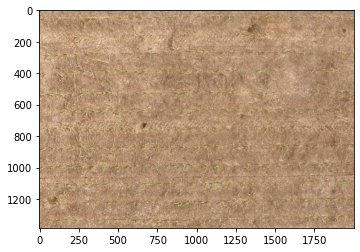

In [7]:
archivos=['dji-0044crop_maiz','dji-0050crop_maiz','dji-0342crop_maiz','dji-0369crop_maiz']
archivos2=['dji-0001crop','dji-0002crop','dji-0003crop','dji-0004crop','dji-0005crop']

for nombre in archivos:
  df = gpd.read_file('/content/plantas/Imágenes + Vectorización/carga 1/'+nombre+'_vectorizado_buffer1cm.geojson')
  fname = '/content/plantas/Imágenes + Vectorización/carga 1/'+nombre+'.tif'

  # Read raster
  with rasterio.open(fname) as r:
      T0 = r.transform  # upper-left pixel corner affine transform
      p1 = Proj(r.crs)
      A = r.read()
  plantas={'id':[],'coord':[],'minx':[],'maxx':[],'miny':[],'maxy':[]}
  for i in range(0,len(df)):
    a=df['geometry'][i]
    points = []
    for polygon in a:
      points.extend(polygon.exterior.coords[:-1])
    points =np.array([point for polygon in a for point in polygon.exterior.coords[:-1]])
    points[:,0]=np.int16((points[:,0]-T0[2])/T0[0])
    points[:,1]=np.int16((points[:,1]-T0[5])/T0[4])
    minx, maxx, miny, maxy=np.int16(np.min(points[:,0])), np.int16(np.max(points[:,0])),np.int16(np.min(points[:,1])), np.int16(np.max(points[:,1]))
    #plantas.append({'coord':points,'extrem':[[minx,maxx],[miny,maxy]]})
    plantas['id'].append(i), plantas['coord'].append(points), plantas['minx'].append(minx),plantas['maxx'].append(maxx),plantas['miny'].append(miny),plantas['maxy'].append(maxy)
  image=gdal.Open(fname).ReadAsArray().transpose([1,2,0])
  print(np.shape(image))
  plt.imshow(image)
  n=[np.shape(image)[0]//512,np.shape(image)[1]//512]
  for i in range(0,n[0]):
    for j in range(0,n[1]):
      recorte=image[i*512:(i+1)*512,j*512:(j+1)*512,:]
      cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".png",recorte)
      pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
      np.save("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,i*512] for t in pos])
    recorte=image[i*512:(i+1)*512,np.shape(image)[1]-512:np.shape(image)[1],:]
    cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
    np.save("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,i*512] for t in pos])

  for j in range(0,n[1]):
    recorte=image[np.shape(image)[0]-512:np.shape(image)[0],j*512:(j+1)*512,:]
    cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
    np.save("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,np.shape(image)[0]-512] for t in pos])

  recorte=image[np.shape(image)[0]-512:np.shape(image)[0],np.shape(image)[1]-512:np.shape(image)[1],:]
  cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
  np.save("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,np.shape(image)[0]-512] for t in pos])

for nombre in archivos2:
  df = gpd.read_file('/content/plantas/Imágenes + Vectorización/carga 2/'+nombre+'_buffer1cm.geojson')
  fname = '/content/plantas/Imágenes + Vectorización/carga 2/'+nombre+'.tif'

  # Read raster
  with rasterio.open(fname) as r:
      T0 = r.transform  # upper-left pixel corner affine transform
      p1 = Proj(r.crs)
      A = r.read()
  plantas={'id':[],'coord':[],'minx':[],'maxx':[],'miny':[],'maxy':[]}
  for i in range(0,len(df)):
    a=df['geometry'][i]
    points = []
    for polygon in a:
      points.extend(polygon.exterior.coords[:-1])
    points =np.array([point for polygon in a for point in polygon.exterior.coords[:-1]])
    points[:,0]=np.int16((points[:,0]-T0[2])/T0[0])
    points[:,1]=np.int16((points[:,1]-T0[5])/T0[4])
    minx, maxx, miny, maxy=np.int16(np.min(points[:,0])), np.int16(np.max(points[:,0])),np.int16(np.min(points[:,1])), np.int16(np.max(points[:,1]))
    #plantas.append({'coord':points,'extrem':[[minx,maxx],[miny,maxy]]})
    plantas['id'].append(i), plantas['coord'].append(points), plantas['minx'].append(minx),plantas['maxx'].append(maxx),plantas['miny'].append(miny),plantas['maxy'].append(maxy)
  image=gdal.Open(fname).ReadAsArray().transpose([1,2,0])
  print(np.shape(image))
  plt.imshow(image)
  n=[np.shape(image)[0]//512,np.shape(image)[1]//512]
  for i in range(0,n[0]):
    for j in range(0,n[1]):
      recorte=image[i*512:(i+1)*512,j*512:(j+1)*512,:]
      cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".png",recorte)
      pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
      np.save("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,i*512] for t in pos])
    recorte=image[i*512:(i+1)*512,np.shape(image)[1]-512:np.shape(image)[1],:]
    cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
    np.save("/content/plantas/conj_ima/"+nombre+"_"+str(i)+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,i*512] for t in pos])

  for j in range(0,n[1]):
    recorte=image[np.shape(image)[0]-512:np.shape(image)[0],j*512:(j+1)*512,:]
    cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
    np.save("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,np.shape(image)[0]-512] for t in pos])

  recorte=image[np.shape(image)[0]-512:np.shape(image)[0],np.shape(image)[1]-512:np.shape(image)[1],:]
  cv2.imwrite("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
  np.save("/content/plantas/conj_ima/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,np.shape(image)[0]-512] for t in pos])


In [8]:
fileDir = r"/content/plantas/"
fileExt = r".png"
list_train_png=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(fileExt)]
list_train_npy=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(r".npy")]
list_test_png=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(fileExt)]
list_test_npy=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(r".npy")]


In [15]:
from numpy.ma.core import sort
pos=[_ for _ in sort(os.listdir('/content/plantas/conj_ima'))[0:121] if _.endswith(fileExt)]
rd.shuffle(pos)
split = int(0.8 *len(pos))
train=pos[-split:]
test=pos[:-split]


In [16]:
for i in test:
  list_test_png.append(i)
  list_test_npy.append(i[:-3]+'npy')
for i in train:
  list_train_png.append(i)
  list_train_npy.append(i[:-3]+'npy')


In [18]:
for i,j in zip(list_train_png,list_train_npy):
  shutil.copy("/content/plantas/conj_ima/"+i,"/content/plantas/train/"+i)
  shutil.copy("/content/plantas/conj_ima/"+j,"/content/plantas/train/"+j)
for i,j in zip(list_test_png,list_test_npy):
  shutil.copy("/content/plantas/conj_ima/"+i,"/content/plantas/test/"+i)
  shutil.copy("/content/plantas/conj_ima/"+j,"/content/plantas/test/"+j)


In [ ]:
#Correr si solo queremos hacer un nuevo conj de testeo y entrenamiento

fileDir = r"/content/drive/Shareddrives/Conteo de plantas/conj_ima/"
fileExt = r".png"
data_list_png=[_ for _ in os.listdir(fileDir) if _.endswith(fileExt)]
data_list_npy=[_ for _ in os.listdir(fileDir) if _.endswith(r".npy")]
pos=[l for l in range(0,len(data_list_png))]
rd.shuffle(pos)
split = int(0.8 *len(data_list))
train=pos[-split:]
test=pos[:-split]
list_train_png=[data_list_png[t] for t in train]
list_train_npy=[data_list_npy[t] for t in train]
list_test_png=[data_list_png[t] for t in test]
list_test_npy=[data_list_npy[t] for t in test]

In [20]:
aver=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_test_npy:
  a=np.load("/content/plantas/test/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/test/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    aver.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
np.savetxt("/content/plantas/test/numpy_test.csv", aver, delimiter =",",fmt ='% s')
# with open("/content/drive/Shareddrives/Conteo de plantas/conj_ima/test/numpy_test.csv", 'w', newline='') as file:
#     writer = csv.writer(file, quoting=csv.QUOTE_ALL,delimiter=';')
#     writer.writerows(aver)


In [21]:
aver=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_train_npy:
  a=np.load("/content/plantas/train/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/train/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    aver.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
np.savetxt("/content/plantas/train/numpy_train.csv", aver, delimiter =",",fmt ='% s')